In [67]:
import torch
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error, mean_squared_log_error, median_absolute_error, explained_variance_score



In [68]:


def load_data(file_path, column, rows=None):
    """Generic function to load data from an Excel file."""
    df = pd.read_excel(file_path)
    return list(df[column][rows]) if rows else list(df[column])

POTENTIATION_DATASETS = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "potentiation (mS)", range(30)),
    "pradeep_new_data":("data/pradeep_new_data.xlsx", "Conductance", range(680)),
    "vivek": ("data/new_data_50_pulses.xlsx", "Potentiation", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Potentiation", range(128)),
    "rahul":("data/64_pot_dep_1.xlsx", "Depression", range(64))
}
DEPRESSION_DATASETS = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "Depression", None),
    "pradeep_new_data":("data/pradeep_new_data.xlsx", "Conductance", range(680, 1358)),
    "vivek": ("data/new_data_50_pulses.xlsx", "Depression", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Depression", None),
    "rahul":("data/64_pot_dep_1.xlsx", "Depression", range(63, 127))
}
# Select potentiation data
data_choice = "rahul" 

potentiation_conductances = load_data(*POTENTIATION_DATASETS.get(data_choice, (None, None, None)))
depression_conductances = load_data(*DEPRESSION_DATASETS.get(data_choice, (None, None, None)))



In [69]:
def adjusted_list(values, flag = True):
    new_values = values[:1]  # Start with the first element
    for i in range(1, len(values)):
        if flag:
            new_values.append(max(new_values[-1], values[i]))  # Ensure non-decreasing order
        else:
            new_values.append(min(new_values[-1], values[i]))  # Ensure non-decreasing order

    return new_values

adjusted_potentiation = adjusted_list(potentiation_conductances)
adjusted_depression = adjusted_list(depression_conductances, False)

In [70]:
len(adjusted_potentiation), len(adjusted_depression)

(64, 64)

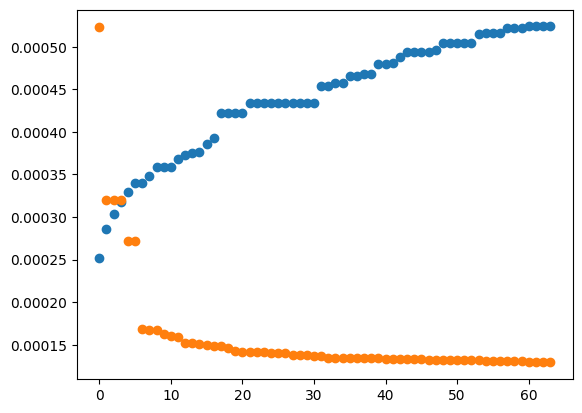

In [71]:
plt.scatter(range(len(adjusted_potentiation)), adjusted_potentiation)
plt.scatter(range(len(adjusted_depression)), adjusted_depression)

In [72]:

class MonotonicApproximator:
    def __init__(self, x: list, y: list):
        self.x = np.array(x)
        self.y = np.array(y)
        
        # Fit an isotonic regression model
        self.isotonic_regressor = IsotonicRegression(increasing='auto')
        self.y_fit = self.isotonic_regressor.fit_transform(self.x, self.y)
        
        # Fit inverse mapping
        self.inverse_isotonic_regressor = IsotonicRegression(increasing='auto')
        self.x_fit = self.inverse_isotonic_regressor.fit_transform(self.y, self.x)
    
    def predict(self, x_tensor: torch.Tensor) -> torch.Tensor:
        device = x_tensor.device
        x_np = x_tensor.cpu().numpy()
        y_pred_np = np.interp(x_np, self.x, self.y_fit)
        return torch.tensor(y_pred_np, dtype=x_tensor.dtype, device=device)
    
    def predict_inverse(self, y_tensor: torch.Tensor) -> torch.Tensor:
        device = y_tensor.device
        y_np = y_tensor.cpu().numpy()
        x_pred_np = np.interp(y_np, self.y_fit, self.x)
        return torch.tensor(x_pred_np, dtype=y_tensor.dtype, device=device)
    
    def evaluate(self):
        mse = mean_squared_error(self.y, self.y_fit)
        rmse = np.sqrt(mse)
        r2 = r2_score(self.y, self.y_fit)
        mae = mean_absolute_error(self.y, self.y_fit)
        max_err = max_error(self.y, self.y_fit)
        median_ae = median_absolute_error(self.y, self.y_fit)
        explained_var = explained_variance_score(self.y, self.y_fit)
        
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"R^2 Score: {r2:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"Max Error: {max_err:.6f}")
        print(f"Median Absolute Error: {median_ae:.6f}")
        print(f"Explained Variance Score: {explained_var:.6f}")
    
    def plot(self):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        
        # Original function
        axs[0].scatter(self.x, self.y, label="Data Points", color='red')
        axs[0].plot(self.x, self.y_fit, label="Monotonic Fit", color='blue')
        axs[0].legend()
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("y")
        axs[0].set_title("Monotonic Approximation")
        
        # Inverse function
        axs[1].scatter(self.y, self.x, label="Data Points", color='red')
        axs[1].plot(self.y_fit, self.x, label="Inverse Monotonic Fit", color='blue')
        axs[1].legend()
        axs[1].set_xlabel("y")
        axs[1].set_ylabel("x")
        axs[1].set_title("Inverse Monotonic Approximation")
        
        plt.show()

MSE: 0.000000
RMSE: 0.000011
R^2 Score: 0.976381
MAE: 0.000004
Max Error: 0.000073
Median Absolute Error: 0.000002
Explained Variance Score: 0.976381


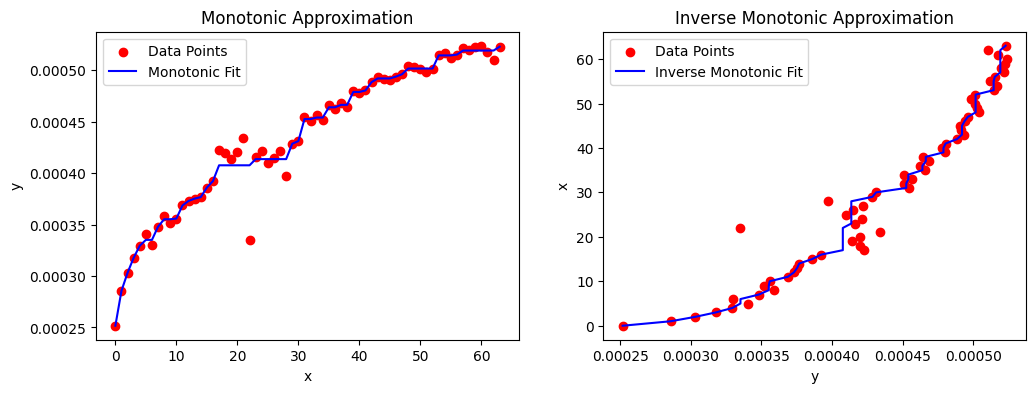

In [73]:

# Example usage:
# x = [0, 1, 2, 3, 4, 5]
# y = [0, 0.8, 0.9, 0.1, -0.8, -1]
spline_approximator = MonotonicApproximator(list(range(len(potentiation_conductances))), potentiation_conductances)
spline_approximator.evaluate()
spline_approximator.plot()


In [74]:

x_test = torch.tensor([1.5, 2.5, 3.5], dtype=torch.float32, device='cuda')
y_pred = spline_approximator.predict(x_test)
print(y_pred)

tensor([0.0003, 0.0003, 0.0003], device='cuda:0')
